In [1]:
import numpy as np
import math
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import json
#
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import truncnorm
#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#
import xgboost as xgb

2025-01-16 21:50:59.446961: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 21:50:59.449012: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 21:50:59.460360: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 21:50:59.482706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737035459.529473  412851 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737035459.53

In [2]:
np.random.seed(42)
tf.random.set_seed
n_list = [15, 20]
epochs = {
    n_list[0]: 100,
    n_list[1]: 100
}

In [16]:
def levy(x, n):
    """
    Levy function
    Global minimum: f(x*) = 0 at x* = (1,...,1)
    Search domain: [-10,10]^n
    """
    w = 1 + (x - 1)/4
    term1 = np.sin(np.pi*w[0])**2
    term3 = (w[n-1]-1)**2 * (1 + np.sin(2*np.pi*w[n-1])**2)
    
    sum = 0.0
    for i in range(n-1):
        wi = w[i]
        term2 = (wi-1)**2 * (1 + 10*np.sin(np.pi*wi + 1)**2)
        sum += term2
        
    return term1 + sum + term3

def get_truncated_normal(mean=5, sd=1, low=0, upp=10, size=None):
    """normal distribution between 0 and 10"""
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(size)

def generate_x(n, k):
    """
    generate n dimensional normal distribution array in range [0, 10] (mit gaussian standard!!!)
    n: how many columns to generate
    k : how many rows to generate
    """
    x = np.array([get_truncated_normal(size=k) for _ in range(n)])
    return x

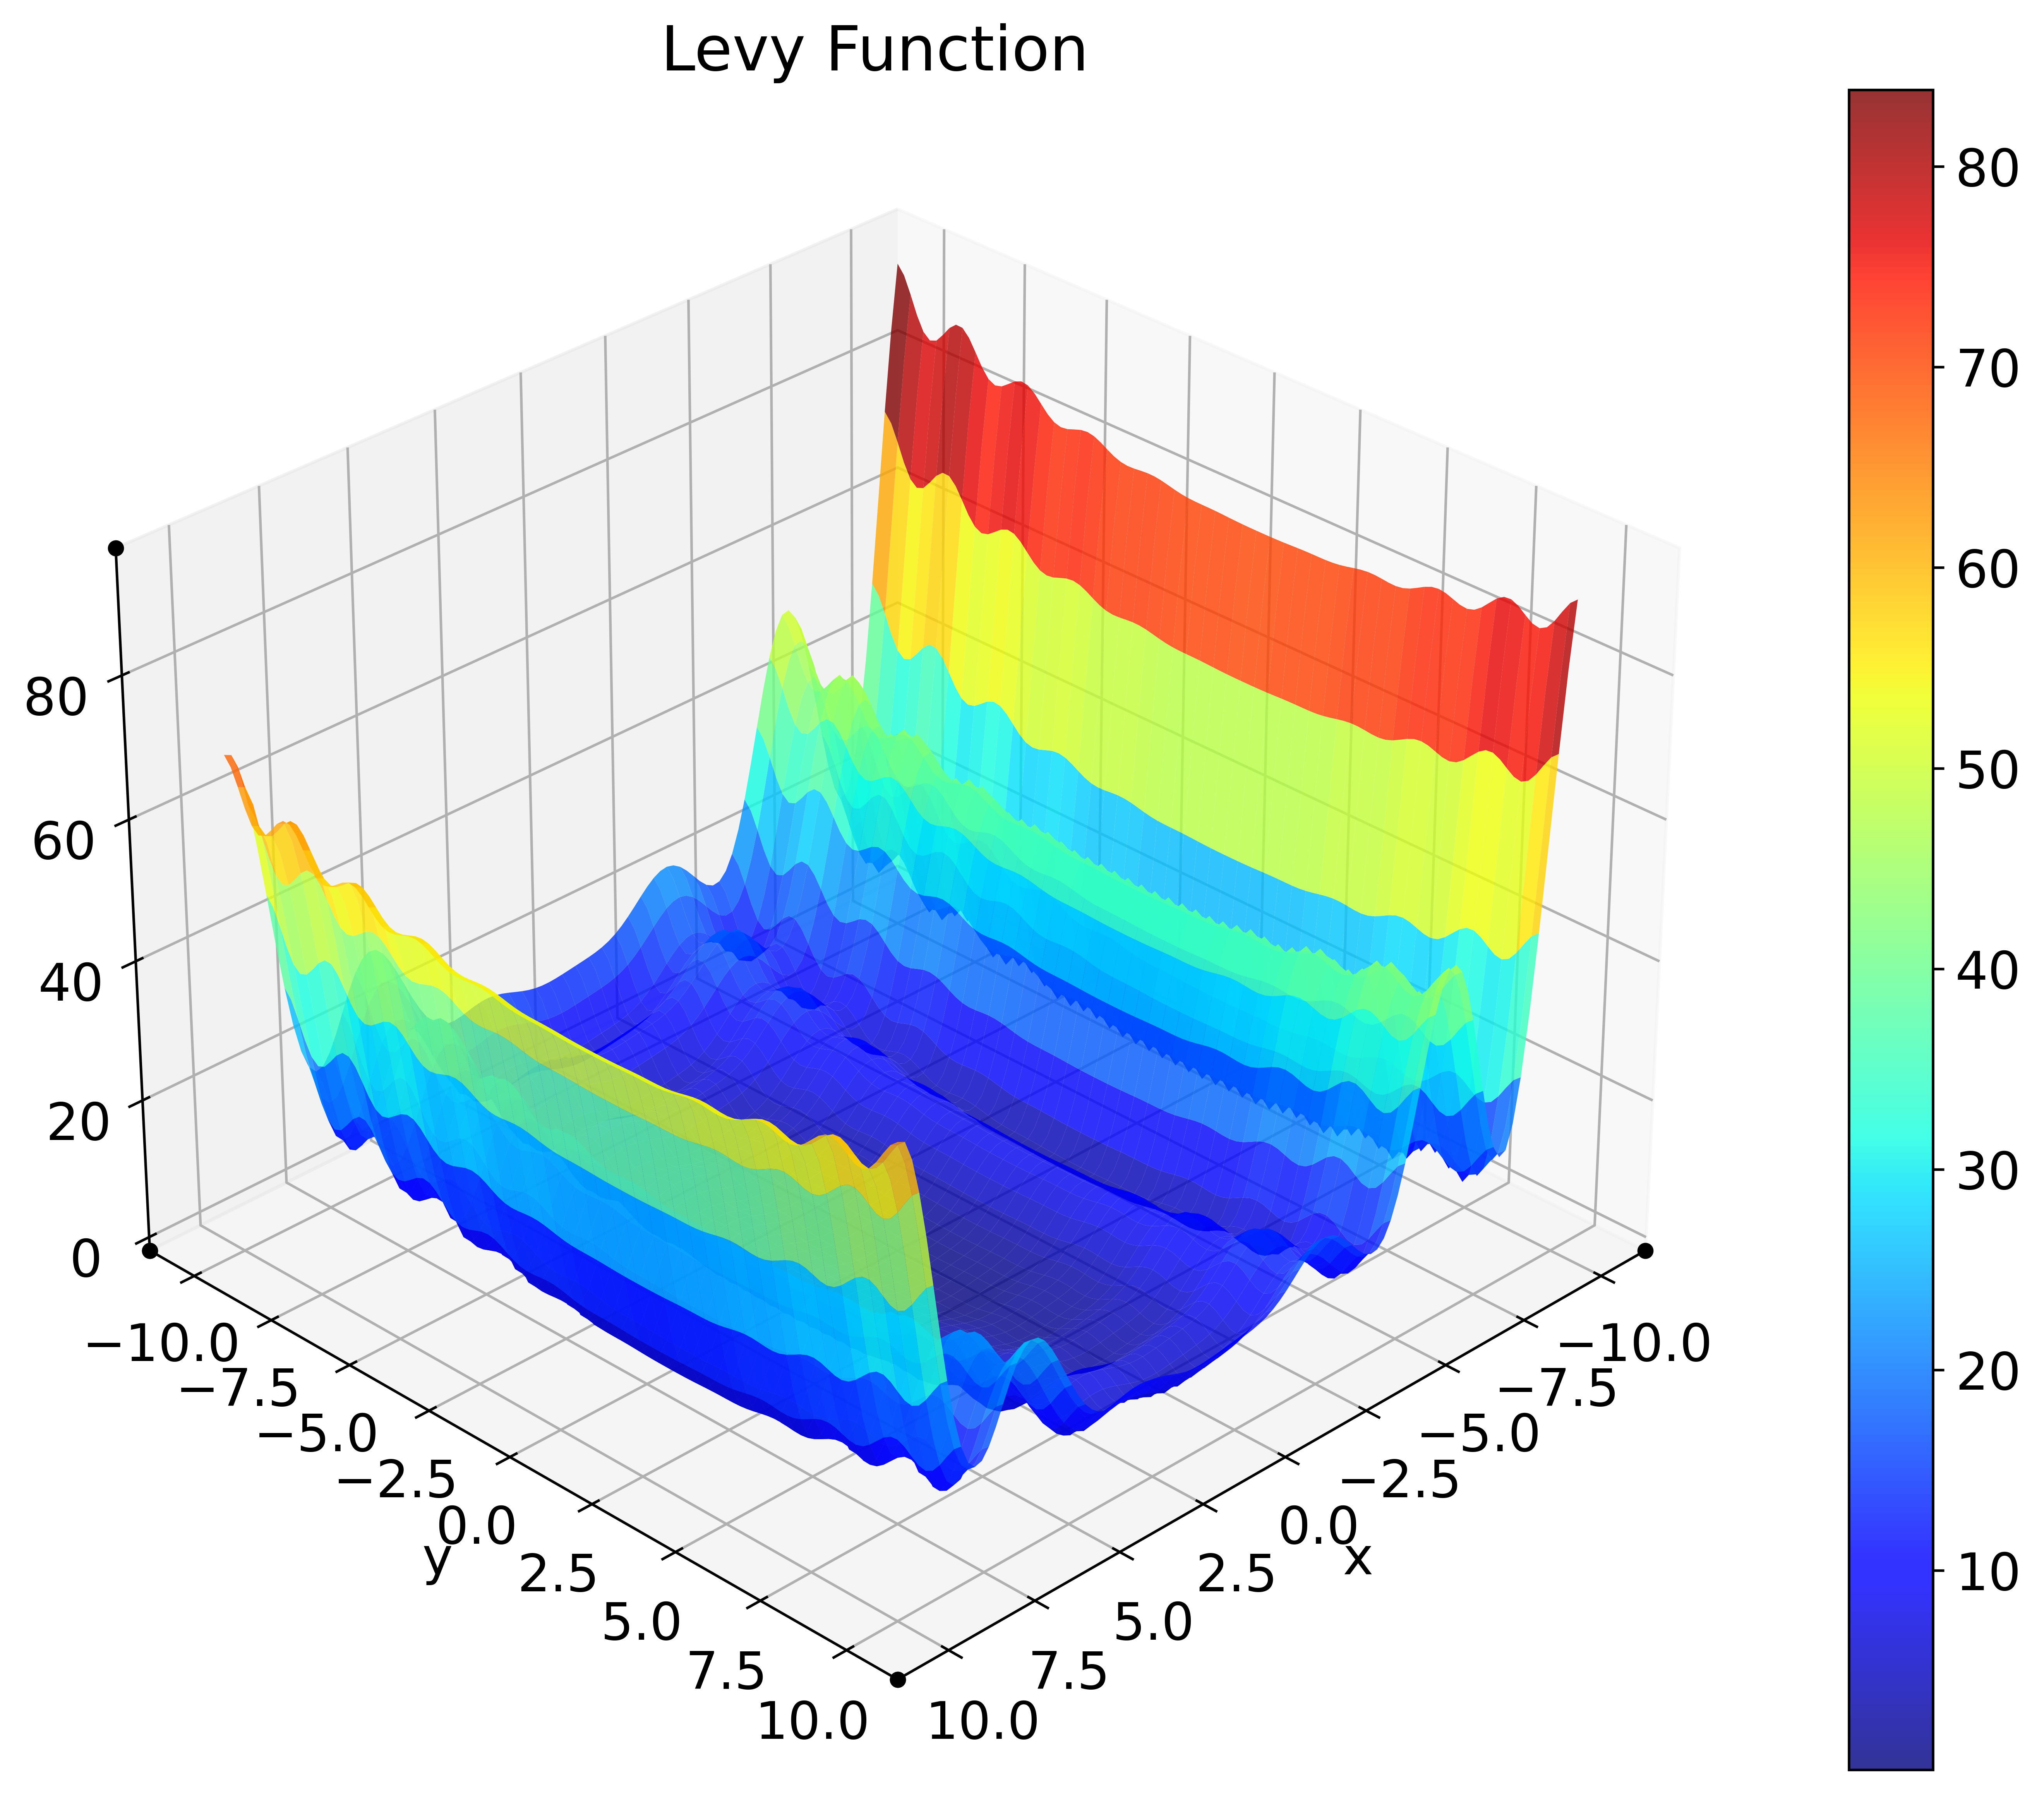

In [10]:
# plot a multidiemensional version of rosenbrock function
plt.rcParams.update({'figure.figsize':(12,6), 'figure.dpi':600, 
                     'lines.markersize': 4, 'lines.markeredgecolor': 'k', 'lines.marker': 'o',
                     'font.size': 16, 'legend.fontsize': 15,})

from mpl_toolkits.mplot3d import Axes3D

def levy_2d(x, y):
    w1 = 1 + (x - 1)/4
    w2 = 1 + (y - 1)/4
    term1 = np.sin(np.pi*w1)**2
    term2 = (w1-1)**2 * (1 + 10*np.sin(np.pi*w1 + 1)**2)
    term3 = (w2-1)**2 * (1 + np.sin(2*np.pi*w2)**2)
    return term1 + term2 + term3

# Create coordinate grid
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = levy_2d(X, Y)

# Create 3D visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, Z, cmap='jet', alpha=0.8)
#ax.contour(X, Y, Z, zdir='z', offset=np.min(Z), cmap='viridis')

# Customize plot
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_zlabel('f(x,y)')
ax.set_title('Levy Function')
plt.colorbar(surf)
plt.tight_layout()
# Set viewing angle
ax.view_init(elev=30, azim=45)

In [11]:
def create_data(n, k=100_000, verbose=True):
    X = generate_x(n=n, k=k)
    y = levy(X, n)
    columns_name = [f'x_{i}' for i in range(n)]
    #
    df = pd.DataFrame(X.T, columns=columns_name)
    df["y"] = y
    #
    if verbose:
        df.head()
        df.describe()
    #
    X = df.drop('y', axis = 1)
    y = df['y']
    return X, y

## Train neural network and XGBoost model

In [17]:
def build_and_compile_ann(lr):
    model = keras.Sequential([
      layers.Dense(64, activation='relu'), 
      layers.Dense(128, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(lr))
    return model

def train_ann(X_train, y_train, epochs, lr):
    ann_model = build_and_compile_ann(lr)
    history = ann_model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        verbose=0, epochs=epochs)
    return ann_model, history

def train_xgb(X_train, y_train):
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    xgb_model.fit(X_train, y_train)
    return xgb_model

In [18]:
metadata = {}
for n in n_list:
    X, y = create_data(n)
    X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(X, y, test_size=0.1)
    X_train = X_df_train.values
    y_train = y_df_train.values
    #
    print(f"Training models for {n} variables")
    xgb_model = train_xgb(X_train, y_train)
    #lr = 0.001 if n == 10 else 0.01 # learning rate
    ann_model, history = train_ann(X_train, y_train, epochs=epochs[n], lr=0.002)
    #
    y_pred_ann = ann_model.predict(X_df_test)
    y_pred_xgb = xgb_model.predict(X_df_test.values)
    r2_ann = r2_score(y_df_test, y_pred_ann.flatten())
    mse_ann = mean_squared_error(y_df_test, y_pred_ann.flatten())
    r2_xgb = r2_score(y_df_test, y_pred_xgb)
    mse_xgb = mean_squared_error(y_df_test, y_pred_xgb)
    print(f"R2 score of ANN ({n} variables): ", r2_ann)
    print(f"R2 score of XGBoost ({n} variables): ", r2_xgb)
    #
    metadata_n = {'ANN_R2': r2_ann,'ANN_MSE':mse_ann, 'XGB_R2': r2_xgb,'XGB_MSE':mse_xgb, 'epochs': epochs[n]}
    metadata[n] = metadata_n
    #
    ann_model.save(f'models/ANN_{n}.h5')
    xgb_model.save_model(f'models/XGB_{n}.json')

with open('models/metadata.json', 'w') as file:
    json.dump(metadata, file)

print("Training complete")

Training models for 15 variables
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


R2 score of ANN (15 variables):  0.9280866769916327
R2 score of XGBoost (15 variables):  0.9539340889841724
Training models for 20 variables
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step


R2 score of ANN (20 variables):  0.800887534516908
R2 score of XGBoost (20 variables):  0.938781537661811
Training complete
